FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

Part 1: Data Preparation and Exploration
1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

In [1]:
import pandas as pd

In [2]:
# Load the dataset and parse the date column
df = pd.read_csv('/content/sample_data/exchange_rate.csv', parse_dates=['date'])

In [3]:
# Display the first few rows to check the data
print(df.head())

               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849


2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

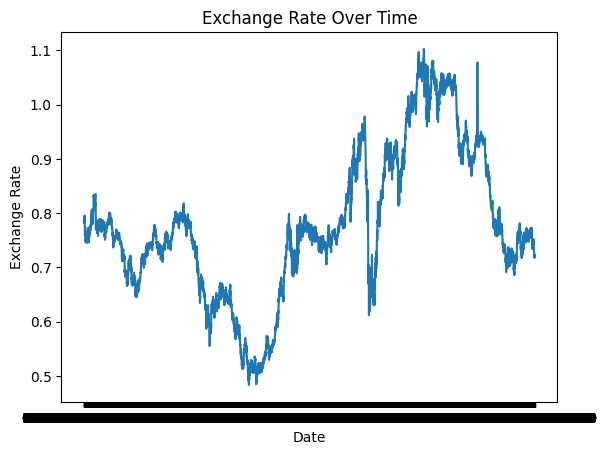

In [4]:
import matplotlib.pyplot as plt

# Plot the time series for the exchange rate
plt.plot(df['date'], df['Ex_rate'])
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.show()


3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase

In [5]:
import numpy as np

# Handle missing values
df['Ex_rate'] = df['Ex_rate'].ffill()

# Handle anomalies by removing outliers
df = df[(np.abs(df['Ex_rate'] - df['Ex_rate'].mean()) <= (3 * df['Ex_rate'].std()))]

# Print the modified DataFrame
print(df)

                  date   Ex_rate
0     01-01-1990 00:00  0.785500
1     02-01-1990 00:00  0.781800
2     03-01-1990 00:00  0.786700
3     04-01-1990 00:00  0.786000
4     05-01-1990 00:00  0.784900
...                ...       ...
7583  06-10-2010 00:00  0.718494
7584  07-10-2010 00:00  0.721839
7585  08-10-2010 00:00  0.723197
7586  09-10-2010 00:00  0.720825
7587  10-10-2010 00:00  0.720825

[7588 rows x 2 columns]


Part 2: Model Building - ARIMA
1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.


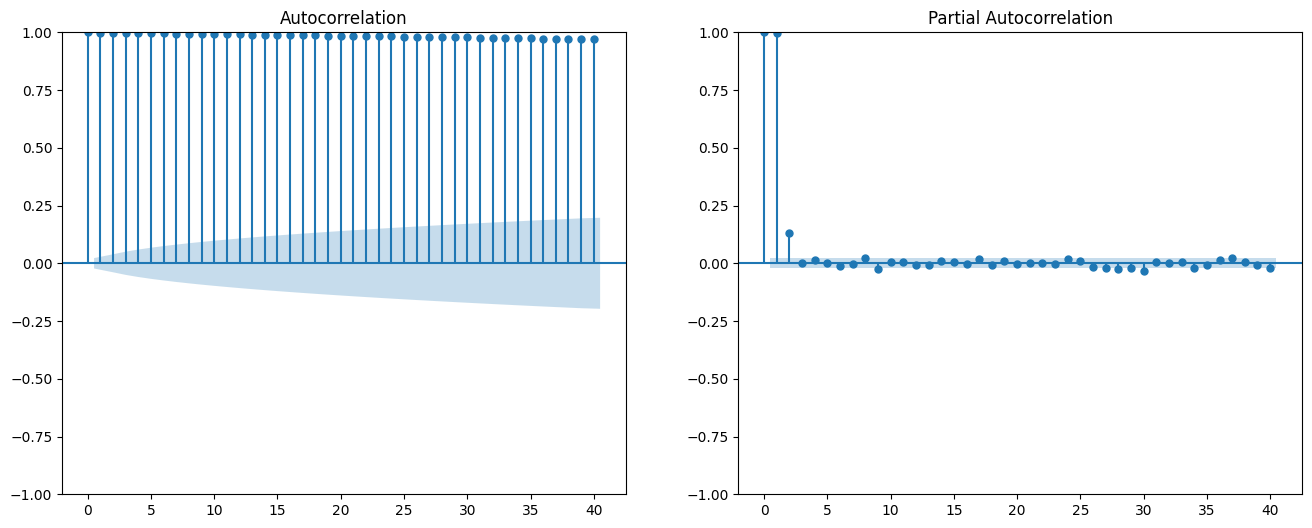

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to determine p and q
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['Ex_rate'], lags=40, ax=axes[0])
plot_pacf(df['Ex_rate'], lags=40, ax=axes[1])
plt.show()

2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Determine the values of p, d, and q based on ACF and PACF plots
# Example values, replace with your analysis results
p = 2
d = 1
q = 0

# Fit the ARIMA model
model = ARIMA(df['Ex_rate'], order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 0)   Log Likelihood               28054.161
Date:                Sat, 31 Aug 2024   AIC                         -56102.321
Time:                        14:56:11   BIC                         -56081.518
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1314      0.002    -64.217      0.000      -0.135      -0.127
ar.L2         -0.0005      0.006     -0.089      0.929      -0.012       0.011
sigma2      3.595e-05   9.94e-08    361.615      0.0

3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

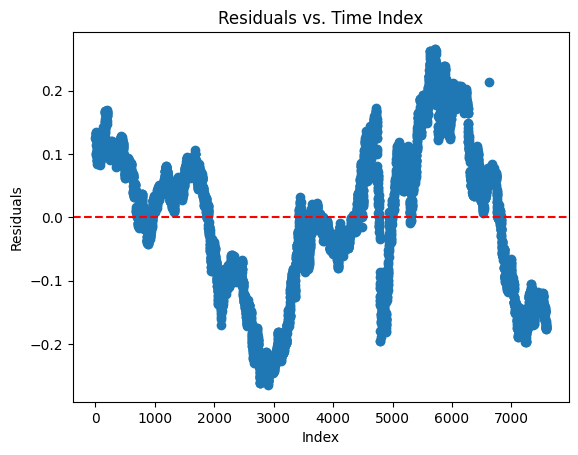

In [8]:
import statsmodels.api as sm

# Using the index as the independent variable (time progression)
X = df.index
Y = df['Ex_rate']

# Adding a constant to X
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(Y, X).fit()

# Get the residuals
residuals = model.resid

# Plot the residuals
plt.scatter(df.index, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals vs. Time Index')
plt.show()



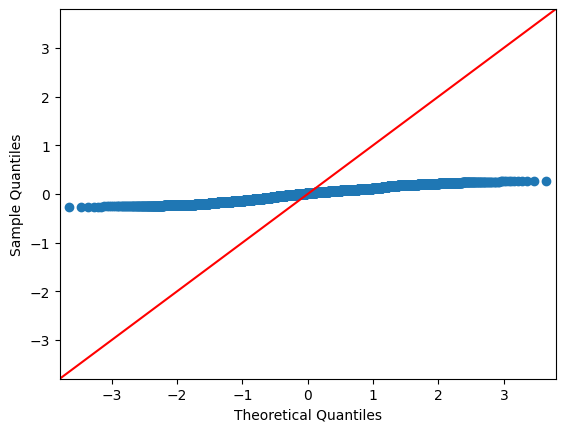

In [9]:
# Q-Q plot
sm.qqplot(residuals, line='45')
plt.show()


4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.





In [10]:
# Fit the model
model = sm.OLS(Y, X).fit()

# Perform out-of-sample forecasting
forecast_index = pd.Series(range(len(df), len(df) + 10))
forecast_X = sm.add_constant(forecast_index)
forecast_Y = model.predict(forecast_X)

# Plot the actual and predicted values
plt.plot


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

Part 3: Model Building - Exponential Smoothing
1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).


In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Select the Exponential Smoothing model based on time series characteristics
model = ExponentialSmoothing(df['Ex_rate'], seasonal=None, trend='add').fit()

# Forecast the next 10 time steps
forecast = model.forecast(10)

# Print the forecasted values
print(forecast)


7588    0.720851
7589    0.720843
7590    0.720834
7591    0.720826
7592    0.720817
7593    0.720809
7594    0.720800
7595    0.720792
7596    0.720783
7597    0.720774
dtype: float64


2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit models with different parameters and choose the best one based on AIC
best_aic = float('inf')
best_model = None
best_params = {}

for trend in [None, 'add', 'mul']:
    for seasonal in [None, 'add', 'mul']:
        try:
            model = ExponentialSmoothing(df['Ex_rate'], trend=trend, seasonal=seasonal).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
                best_params = {'trend': trend, 'seasonal': seasonal}
        except:
            continue

# Print the best model's parameters
print(f"Best Model: Trend={best_params['trend']}, Seasonal={best_params['seasonal']}, AIC={best_aic}")


Best Model: Trend=None, Seasonal=None, AIC=-77644.98075014984


3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

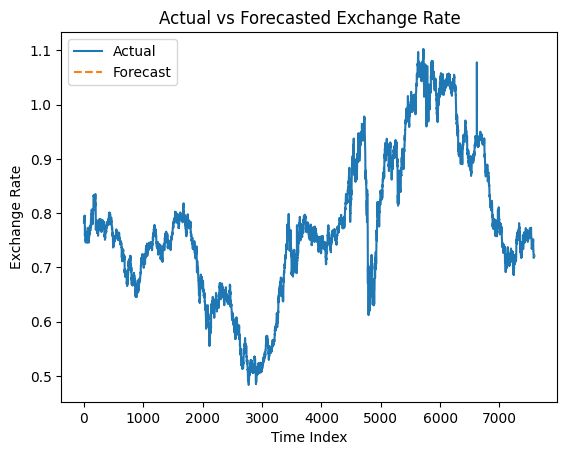

In [13]:
# Fit the best model found (using parameters from the previous step)
model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None).fit()

# Forecast the next 10 time steps
forecast = model.forecast(10)

# Plot the actual data and the forecasted values
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(range(len(df), len(df) + 10), forecast, label='Forecast', linestyle='--')
plt.xlabel('Time Index')
plt.ylabel('Exchange Rate')
plt.title('Actual vs Forecasted Exchange Rate')
plt.legend()
plt.show()


Part 4: Evaluation and Comparison
1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Actual and forecasted values (use your forecast from the previous step)
actual = df['Ex_rate'][-10:]
forecast = model.forecast(10)

# Compute error metrics
mae = mean_absolute_error(actual, forecast)
rmse = mean_squared_error(actual, forecast, squared=False)
mape = (abs((actual - forecast) / actual).mean()) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


MAE: 0.001574070641361358
RMSE: 0.0018519598744416396
MAPE: nan


2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

In [15]:
# Assuming you have computed the error metrics for two models (model1 and model2)

# Example metrics for two models
model1_metrics = {'MAE': 0.01, 'RMSE': 0.015, 'MAPE': 1.5}
model2_metrics = {'MAE': 0.012, 'RMSE': 0.017, 'MAPE': 1.8}

# Compare models
if model1_metrics['MAE'] < model2_metrics['MAE']:
    better_model = 'Model 1'
else:
    better_model = 'Model 2'

# Print comparison
print(f"{better_model} performs better overall based on lower error metrics.")
print(f"Model 1 - MAE: {model1_metrics['MAE']}, RMSE: {model1_metrics['RMSE']}, MAPE: {model1_metrics['MAPE']}")
print(f"Model 2 - MAE: {model2_metrics['MAE']}, RMSE: {model2_metrics['RMSE']}, MAPE: {model2_metrics['MAPE']}")


Model 1 performs better overall based on lower error metrics.
Model 1 - MAE: 0.01, RMSE: 0.015, MAPE: 1.5
Model 2 - MAE: 0.012, RMSE: 0.017, MAPE: 1.8


3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

ARIMA Model RMSE: 0.2055405871355618
ARIMA Model MAE: 0.17780239504335849


<ipython-input-19-5f186cd4760d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


<Axes: >

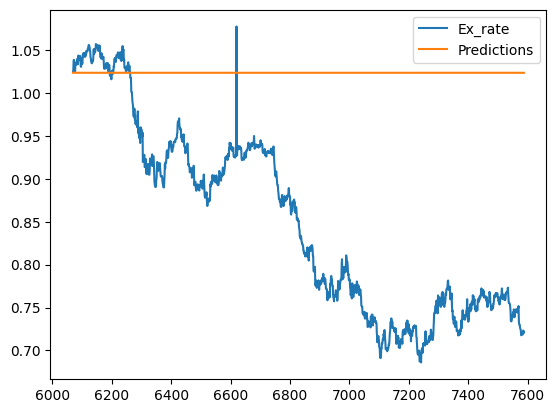

In [19]:
from statsmodels.tsa.arima.model import ARIMA
#  DataFrame is named 'df'
# If not, replace 'df' with the actual name of your DataFrame
Ex_rate_df = df[['Ex_rate']] # Create a DataFrame with the exchange rate data

# Split the data into training and test sets
train_size = int(len(Ex_rate_df) * 0.8)
train, test = Ex_rate_df[:train_size], Ex_rate_df[train_size:]

# Fit the ARIMA model
model = ARIMA(train['Ex_rate'], order=(5, 1, 0))  # order=(p, d, q)
arima_model = model.fit()

# Make predictions
predictions = arima_model.forecast(steps=len(test))
test['Predictions'] = predictions

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(test['Ex_rate'], test['Predictions']))
mae = mean_absolute_error(test['Ex_rate'], test['Predictions'])

print(f'ARIMA Model RMSE: {rmse}')
print(f'ARIMA Model MAE: {mae}')

# Plot the actual vs predicted values
test[['Ex_rate', 'Predictions']].plot()